# Computer Vision

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this notebook we're going to cover the basics of computer vision using CNNs. So far we've explored using CNNs for text but their initial origin began with computer vision tasks.




<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/cnn_cv.png" width=650>

# Set up

In [3]:
!pip3 install torch torchvision
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

    100% |████████████████████████████████| 591.8MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x617d4000 @  0x7f8ca68e42a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 23.0MB/s 
    100% |████████████████████████████████| 2.0MB 4.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 7.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No 

In [0]:
import os
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import re
import torch
from urllib import request
import tarfile
# Don't worry we aren't using tensorflow, just using it to get some data
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import string
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# Data

We're going to first get some data. A popular computer vision classification dataset is [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) which contains images from ten unique classes.

In [0]:
# Don't worry we aren't using tensorflow, just using it to get some data
import tensorflow as tf
import matplotlib.pyplot as plt

In [36]:
# Load data and combine
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
X = np.vstack([x_train, x_test])
y = np.vstack([y_train, y_test]).squeeze(1)
print ("x:", X.shape)
print ("y:", y.shape)

x: (60000, 32, 32, 3)
y: (60000,)


Each image has length 32, width 32 and three color channels (RGB). We are going to save these images in a directory. Each image will have it's own directory (name will be the class).

In [0]:
!rm -rf cifar10_data

In [0]:
# Classes
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 
           6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [0]:
# Create image directories
data_dir = "cifar10_data"
os.mkdir(data_dir)
for _class in classes.values():
    os.mkdir(os.path.join(data_dir, _class))

In [0]:
# Save images for each class
for i, (image, label) in enumerate(zip(X, y)):
    _class = classes[label]
    im = Image.fromarray(image)
    im.save(os.path.join(data_dir, _class, "{0:02d}.png".format(i)))

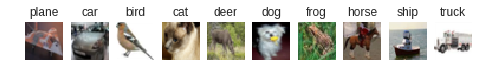

In [41]:
# Visualize some samples
num_samples = len(classes)
for i, _class in enumerate(classes.values()):  
    for file in os.listdir(os.path.join(data_dir, _class)):
        if file.endswith(".png"):
            plt.subplot(1, num_samples, i+1)
            plt.title("{0}".format(_class))
            img = Image.open(os.path.join(data_dir, _class, file))
            plt.imshow(img)
            plt.axis("off")
            break

# Classification

Our task will be to classify the class given the image. We're going to architect a basic CNN to process the input images and produce a classification.

### Arguments

With image data, we won't be save our split data files. We will only read from the image directory.

In [1]:
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    data_dir="cifar10_data",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="cifar10_model",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    num_epochs=10,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=128,
    num_filters=100,
    hidden_dim=100,
    dropout_p=0.1,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

NameError: ignored

### Data

In [0]:
# Convert image file to NumPy array
def img_to_array(fp):
    img = Image.open(fp)
    array = np.asarray(img, dtype="float32")
    return array

In [46]:
# Load data
data = []
for i, _class in enumerate(classes.values()):  
    for file in os.listdir(os.path.join(data_dir, _class)):
        if file.endswith(".png"):
            full_filepath = os.path.join(data_dir, _class, file)
            data.append({"image": img_to_array(full_filepath), "category": _class})

TypeError: ignored

In [0]:
# Convert to Pandas DataFrame
df = pd.DataFrame(data)
print ("Image shape:", df.image[0].shape)
df.head()

In [0]:
by_category = collections.defaultdict(list)
for _, row in df.iterrows():
    by_category[row.category].append(row.to_dict())
for category in by_category:
    print ("{0}: {1}".format(category, len(by_category[category])))

In [0]:
final_list = []
for _, item_list in sorted(by_category.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [17]:
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    42000
test      9000
val       9000
Name: split, dtype: int64

### Vocabulary

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [7]:
# Vocabulary instance
category_vocab = Vocabulary()
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
index = category_vocab.lookup_token("dog")
print (index)
print (category_vocab.lookup_index(index))

NameError: ignored

### Sequence vocabulary

In [0]:
from collections import Counter
import string

In [0]:
class SequenceVocabulary():
    def __init__(self, train_means, train_stds):
        
        self.train_means = train_means
        self.train_stds = train_stds
        
    def to_serializable(self):
        contents = {'train_means': self.train_means,
                    'train_stds': self.train_stds}
        return contents
    
    @classmethod
    def from_dataframe(cls, df):
        train_data = df[df.split == "train"]
        means = {0:[], 1:[], 2:[]}
        stds = {0:[], 1:[], 2:[]}
        for image in train_data.image:
            for dim in range(3):
                means[dim].append(np.mean(image[:, :, dim]))
                stds[dim].append(np.std(image[:, :, dim]))
        train_means = np.array((np.mean(means[0]), np.mean(means[1]), 
                                np.mean(means[2])), dtype="float64").tolist()
        train_stds = np.array((np.mean(stds[0]), np.mean(stds[1]), 
                               np.mean(stds[2])), dtype="float64").tolist()
            
        return cls(train_means, train_stds)
        
    def __str__(self):
        return "<SequenceVocabulary(train_means: {0}, train_stds: {1}>".format(
            self.train_means, self.train_stds)

In [33]:
# Create SequenceVocabulary instance
image_vocab = SequenceVocabulary.from_dataframe(split_df)
print (image_vocab) # __str__

NameError: ignored

### Vectorizer

In [0]:
class ImageVectorizer(object):
    def __init__(self, image_vocab, category_vocab):
        self.image_vocab = image_vocab
        self.category_vocab = category_vocab

    def vectorize(self, image):
        
        # Avoid modifying the actual df
        image = np.copy(image)
        
        # Normalize
        for dim in range(3):
            mean = self.image_vocab.train_means[dim]
            std = self.image_vocab.train_stds[dim]
            image[:, :, dim] = ((image[:, :, dim] - mean) / std)
            
        # Reshape frok (32, 32, 3) to (3, 32, 32)
        image = np.swapaxes(image, 0, 2)
        image = np.swapaxes(image, 1, 2)
                
        return image
    
    @classmethod
    def from_dataframe(cls, df):
        
        # Create class vocab
        category_vocab = Vocabulary()   
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)
            
        # Create image vocab
        image_vocab = SequenceVocabulary.from_dataframe(df)
        
        return cls(image_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        image_vocab = SequenceVocabulary.from_serializable(contents['image_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(image_vocab=image_vocab, 
                   category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'image_vocab': self.image_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [24]:
# Vectorizer instance
vectorizer = ImageVectorizer.from_dataframe(split_df)
print (vectorizer.image_vocab)
print (vectorizer.category_vocab)
image_vector = vectorizer.vectorize(split_df.iloc[0].image)
print (image_vector.shape)

<SequenceVocabulary(train_means: [125.39012908935547, 123.0616226196289, 113.98292541503906], train_stds: [51.596153259277344, 50.85782241821289, 51.26128005981445]>
<Vocabulary(size=10)>
(3, 32, 32)


### Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class ImageDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df):
        train_df = df[df.split=='train']
        return cls(df, ImageVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return ImageVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        image_vector = self.vectorizer.vectorize(row.image)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'image': image_vector, 
                'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [27]:
# Dataset instance
dataset = ImageDataset.load_dataset_and_make_vectorizer(split_df)
print (dataset) # __str__
input_ = dataset[10] # __getitem__
print (input_['image'].shape)
category = input_['category']
print (dataset.vectorizer.category_vocab.lookup_index(category))
print (dataset.class_weights)

<Dataset(split=train, size=42000)
(3, 32, 32)
bird
tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002])


### Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class ImageModel(nn.Module):
    def __init__(self, num_hidden_units, num_classes, dropout_p):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # input_channels:3 , output_channels:10 (aka num filters)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv_dropout = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(20*5*5, num_hidden_units)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x, apply_softmax=False):
          
        # Conv pool
        z = self.conv1(x) # (N, 10, 28, 28)
        z = F.max_pool2d(z, 2) # (N, 10, 14, 14)
        z = F.relu(z)
        
        # Conv pool
        z = self.conv2(z) # (N, 20, 10, 10)
        z = self.conv_dropout(z) 
        z = F.max_pool2d(z, 2) # (N, 20, 5, 5)
        z = F.relu(z)
        
        # Flatten
        z = z.view(-1, 20*5*5)
        
        # FC
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        y_pred = self.fc2(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred 
        

### Training

In [0]:
import torch.optim as optim

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, 
                 shuffle, num_epochs, batch_size, learning_rate, 
                 early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.device = device
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0:02d} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()
                
                # compute the output
                y_pred = self.model(x=batch_dict['image'])
                
                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0, set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred = self.model(x=batch_dict['image'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0, set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = self.model(x=batch_dict['image'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [0]:
# Initialization
dataset = ImageDataset.load_dataset_and_make_vectorizer(split_df)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = ImageModel(num_hidden_units=args.hidden_dim, 
                   num_classes=len(vectorizer.category_vocab),
                   dropout_p=args.dropout_p)
print (model.named_modules)

<bound method Module.named_modules of ImageModel(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_dropout): Dropout2d(p=0.1)
  (fc1): Linear(in_features=500, out_features=100, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)>


In [0]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 1.70 | [TRAIN ACC]: 38.4% | [VAL LOSS]: 1.48 | [VAL ACC]: 47.0%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 1.41 | [TRAIN ACC]: 50.0% | [VAL LOSS]: 1.31 | [VAL ACC]: 52.9%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 1.29 | [TRAIN ACC]: 54.2% | [VAL LOSS]: 1.21 | [VAL ACC]: 57.2%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 1.20 | [TRAIN ACC]: 57.6% | [VAL LOSS]: 1.15 | [VAL ACC]: 59.3%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 1.14 | [TRAIN ACC]: 59.6% | [VAL LOSS]: 1.14 | [VAL ACC]: 59.7%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 1.10 | [TRAIN ACC]: 61.4% | [VAL LOSS]: 1.08 | [VAL ACC]: 61.8%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 1.05 | [TRAIN ACC]: 63.0% | [VAL LOSS]: 1.06 | [VAL ACC]: 62.8%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 1.02 | [TRAIN ACC]: 64.2% | [VAL LOSS]: 1.05 | [VAL ACC]: 63.4%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 0.99 | [TRAIN ACC]: 65.1% | [VAL LOSS]: 1.04 | [VAL ACC]: 63.7%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 0.97

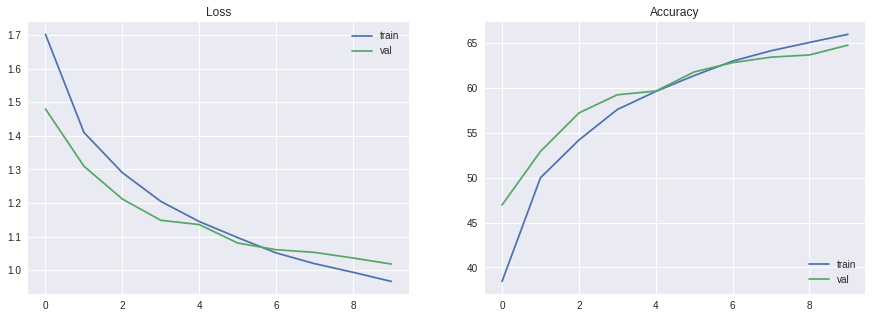

In [0]:
# Plot performance
trainer.plot_performance()

In [0]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 1.00
Test Accuracy: 65.2%


In [0]:
# Save all results
trainer.save_train_state()

~66% test performance for our Cifar10 dataset is not bad but we can do way better.

# Transfer learning

In this section, we're going to use a pretrained model that performs very well on a different dataset. We're going to take the architecture and the initial convolutional weights from the model to use on our data. We will freeze the initial convolutional weights and fine tune the later convolutional and fully-connected layers. 

Transfer learning works here because the initial convolution layers act as excellent feature extractors for common spatial features that are shared across images regardless of their class. We're going to leverage these large, pretrained models' feature extractors for our own dataset.

In [0]:
from torchvision import models

In [0]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
print (model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [0]:
model_name = 'vgg19_bn'
vgg_19bn = models.__dict__[model_name](pretrained=True) # Set false to train from scratch
print (vgg_19bn.named_parameters)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.torch/models/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:10<00:00, 53444578.13it/s]


<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

The VGG model we chose has a `features` and a `classifier` component. The `features` component is composed of convolution and pooling layers which act as feature extractors. The `classifier` component is composed on fully connected layers. We're going to freeze most of the `feature` component and design our own FC layers for our CIFAR10 task. You can access the default code for all models at `/usr/local/lib/python3.6/dist-packages/torchvision/models` if you prefer cloning and modifying that instead.

In [0]:
class ImageModel(nn.Module):
    def __init__(self, feature_extractor, num_hidden_units, 
                 num_classes, dropout_p):
        super(ImageModel, self).__init__()
        
        # Pretrained feature extractor
        self.feature_extractor = feature_extractor
        
        # FC weights
        self.classifier = nn.Sequential(
            nn.Linear(512, 250, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(250, 100, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10, bias=True),
            )

    def forward(self, x, apply_softmax=False):
          
        # Feature extractor
        z = self.feature_extractor(x)
        z = z.view(x.size(0), -1)
        
        # FC
        y_pred = self.classifier(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred 

In [0]:
# Initialization
dataset = ImageDataset.load_dataset_and_make_vectorizer(split_df)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = ImageModel(feature_extractor=vgg_19bn.features, 
                   num_hidden_units=args.hidden_dim,
                   num_classes=len(vectorizer.category_vocab), 
                   dropout_p=args.dropout_p)
print (model.named_parameters)

<bound method Module.named_parameters of ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [0]:
# Finetune last few conv layers and FC layers
for i, param in enumerate(model.feature_extractor.parameters()):
    if i < 36:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [0]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 0.94 | [TRAIN ACC]: 70.8% | [VAL LOSS]: 0.66 | [VAL ACC]: 78.8%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 0.57 | [TRAIN ACC]: 83.2% | [VAL LOSS]: 0.53 | [VAL ACC]: 83.0%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 0.43 | [TRAIN ACC]: 87.3% | [VAL LOSS]: 0.51 | [VAL ACC]: 84.2%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 0.33 | [TRAIN ACC]: 90.5% | [VAL LOSS]: 0.54 | [VAL ACC]: 85.0%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 0.25 | [TRAIN ACC]: 92.9% | [VAL LOSS]: 0.55 | [VAL ACC]: 85.0%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 0.13 | [TRAIN ACC]: 96.4% | [VAL LOSS]: 0.63 | [VAL ACC]: 85.8%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 0.08 | [TRAIN ACC]: 97.8% | [VAL LOSS]: 0.65 | [VAL ACC]: 86.2%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 0.04 | [TRAIN ACC]: 98.9% | [VAL LOSS]: 0.66 | [VAL ACC]: 86.7%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 0.03 | [TRAIN ACC]: 99.3% | [VAL LOSS]: 0.70 | [VAL ACC]: 86.9%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 0.02

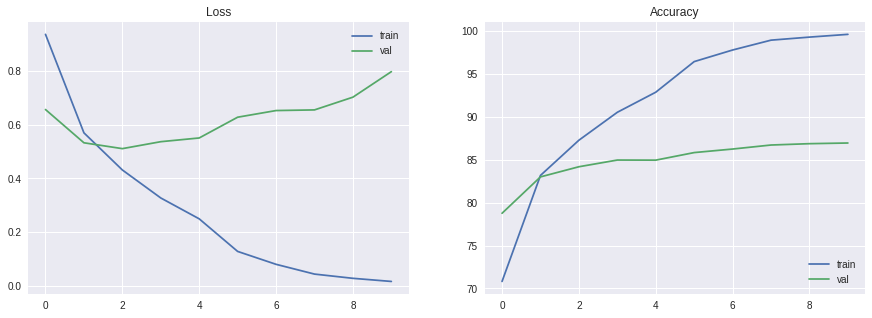

In [0]:
# Plot performance
trainer.plot_performance()

In [0]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.83
Test Accuracy: 86.8%


In [0]:
# Save all results
trainer.save_train_state()

Much better performance! If you let it train long enough, we'll actually reah ~95% accuracy :)

## Inference

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 1, 1

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer):
        self.model = model
        self.model.to("cpu")
        self.vectorizer = vectorizer
  
    def predict_category(self, image):
        # Vectorize
        image_vector = self.vectorizer.vectorize(image)
        image_vector = torch.tensor(image_vector).unsqueeze(0)
        
        # Forward pass
        self.model.eval()
        y_pred = self.model(x=image_vector, apply_softmax=True)

        # Top category
        y_prob, indices = y_pred.max(dim=1)
        index = indices.item()

        # Predicted category
        category = vectorizer.category_vocab.lookup_index(index)
        probability = y_prob.item()
        return {'category': category, 'probability': probability}
    
    def predict_top_k(self, image, k):
        # Vectorize
        image_vector = self.vectorizer.vectorize(image)
        image_vector = torch.tensor(image_vector).unsqueeze(0)
        
        # Forward pass
        self.model.eval()
        y_pred = self.model(x=image_vector, apply_softmax=True)
        
        # Top k categories
        y_prob, indices = torch.topk(y_pred, k=k)
        probabilities = y_prob.detach().numpy()[0]
        indices = indices.detach().numpy()[0]

        # Results
        results = []
        for probability, index in zip(probabilities, indices):
            category = self.vectorizer.category_vocab.lookup_index(index)
            results.append({'category': category, 'probability': probability})

        return results

In [0]:
# Get a sample
sample = split_df[split_df.split=="test"].iloc[1000]

Actual: car
(car → p=0.95)


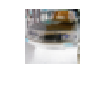

In [0]:
# Inference
inference = Inference(model=model, vectorizer=vectorizer)
prediction = inference.predict_category(sample.image)
print ("Actual:", sample.category)
plt.imshow(sample.image)
plt.axis("off")
print("({} → p={:0.2f})".format(prediction['category'], 
                                prediction['probability']))

Actual: car
car → (p=0.95)
ship → (p=0.05)
plane → (p=0.00)
truck → (p=0.00)
frog → (p=0.00)
dog → (p=0.00)
cat → (p=0.00)
bird → (p=0.00)
deer → (p=0.00)
horse → (p=0.00)


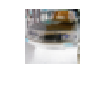

In [0]:
# # Top-k inference
top_k = inference.predict_top_k(sample.image, k=len(vectorizer.category_vocab))
print ("Actual:", sample.category)
plt.imshow(sample.image)
plt.axis("off")
for result in top_k:
    print ("{} → (p={:0.2f})".format(result['category'], 
                                     result['probability']))

# Segmentation

Image senmentation task aims to pixel-wise classification. There are two kinds of segmentation: class segmentation and object segmentation. Former task is to label which class a pixel in while the later one is to label which object each pixel belongs to. 

## Arguments

In [5]:
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    data_dir="VOC2007_data",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="fcn32_model",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    num_epochs=10,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=4,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
#args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: True


## Data
 As  Classification section, we need get some segmentation data for segmentation task. One popular dataset is [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/). In this section, we use VOC2007 as our segmentation dataset. We download, unzip and read images first.

In [12]:
print("downloading with urllib")
url = "http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar"
file='VOCtrainval_06-Nov-2007.tar'
print("downloading with " + file)
LocalPath = os.path.join('./', file)
request.urlretrieve(url, LocalPath)
print(file+' downloaded')
print('unzip file')
tar = tarfile.open('VOCtrainval_06-Nov-2007.tar')
names = tar.getnames()
if os.path.isdir('VOCtrainval_06-Nov-2007'):
    pass
else:
    os.mkdir('VOCtrainval_06-Nov-2007')
for name in names:
    tar.extract(name, 'VOCtrainval_06-Nov-2007')
tar.close()
print('file unzipped')



downloading with urllib
downloading with VOCtrainval_06-Nov-2007.tar
VOCtrainval_06-Nov-2007.tar downloaded
unzip file
file unzipped


422
    index                                              image  \
0  000032  [[[131, 193, 208], [132, 194, 209], [133, 196,...   
1  000033  [[[215, 215, 215], [214, 214, 214], [213, 213,...   
2  000039  [[[166, 167, 149], [169, 173, 151], [163, 167,...   
3  000042  [[[231, 231, 233], [231, 232, 234], [229, 233,...   
4  000061  [[[244, 244, 242], [242, 242, 240], [244, 244,...   

                                                mask  split  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  train  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  train  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  train  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  train  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  train  


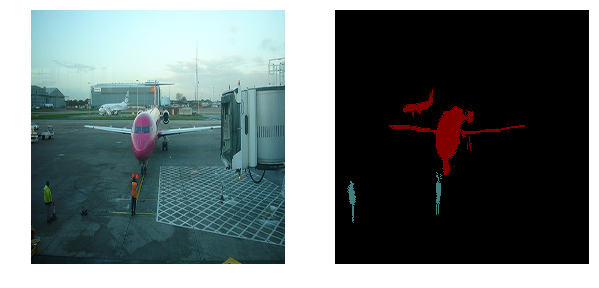

In [6]:
import cv2
images_index=[]
for index in sorted(os.listdir('VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass')):
  images_index.append(index.split('.')[0])
print(len(images_index))
images=[]
masks=[]
splits=[]
for index in images_index:
    image = np.array(Image.open("./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/" + index + '.jpg'))
    mask = np.array(Image.open("./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/" + index + '.png'))
    mask[mask == 255] = 0
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
    #print(np.unique(mask))
    resize_mask=np.zeros([mask.shape[0],mask.shape[1],21])
    resized_mask=[]
    for c in range(21):
        resize_mask[mask == c,c]=1
        resized_mask.append(np.array((cv2.resize(resize_mask[:,:,c],(256,256),interpolation=cv2.INTER_CUBIC)),dtype=np.int32))
    new_mask=np.zeros([256,256],dtype=np.int32)
    for c in range(21):
        new_mask[resized_mask[c]==1]=int(c)
    images.append(image)
    masks.append(new_mask)
n=len(images_index)
for i in range(n):
  if i < n*args.train_size:
    splits.append('train')
  elif i < n*(args.train_size+args.val_size):
    splits.append('val')
  else:
    splits.append('test')

    
color_map={
    0:[0,0,0],
    1:[128,0,0],
    2:[0,128,0],
    3:[128,128,0],
    4:[0,0,128],
    5:[128,0,128],
    6:[0,128,128],
    7:[128,128,128],
    8:[64,0,0],
    9:[192,0,0],
    10:[64,128,0],
    11:[192,128,0],
    12:[64,0,128],
    13:[192,0,128],
    14:[64,128,128],
    15:[192,128,128],
    16:[0,64,0],
    17:[128,64,0],
    18:[0,192,0],
    19:[128,192,0],
    20:[0,64,128]
}
category_map={
    "background":0,
    "aeroplane":1,
    "bicycle":2,
    "bird":3,
    "boat":4,
    "bottle":5,
    "bus":6,
    "car":7,
    "cat":8,
    "chair":9,
    "cow":10,
    "diningtable":11,
    "dog":12,
    "horse":13,
    "motorbike":14,
    "person":15,
    "pottedplant":16,
    "sheep":17,
    "sofa":18,
    "train":19,
    "tvmonitor":20,
}

# visualize the input data
visualize_index=0
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(images[visualize_index])
plt.axis("off")
plt.subplot(1,2,2)
colored_mask=np.zeros([masks[visualize_index].shape[0],masks[visualize_index].shape[1],3])
for k in color_map.keys():
  index=masks[visualize_index]==k
  colored_mask[index]=color_map[k]
plt.imshow(colored_mask)
plt.axis("off")
df=pd.DataFrame()
df['index']=images_index
df['image']=images
df['mask']=masks
df['split']=splits
print(df.head())

## Vocabulary
Image in segmentation task has a label for each pixel, so we parse vocabulary directly from mask map

In [7]:
category_vocab = Vocabulary(category_map)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
index = category_vocab.lookup_token("dog")
print (index)
print (category_vocab.lookup_index(index))

<Vocabulary(size=21)>
21
12
dog


## Sequence vocabulary
It's same with sequence vocabulary in last section

In [8]:
# Create SequenceVocabulary instance
image_vocab = SequenceVocabulary.from_dataframe(df)
print (image_vocab) # __str__

<SequenceVocabulary(train_means: [114.8360842627448, 109.73992925076871, 100.7763970349286], train_stds: [59.73416304143838, 58.514234519746225, 59.124137101325786]>


## Vectorizor

In [0]:
class ImageSegmentationVectorizer(object):
    def __init__(self, image_vocab):
        self.image_vocab = image_vocab
        self.category_vocab = category_vocab

    def vectorize(self, image,mask):
        
        # Avoid modifying the actual df
        image = np.copy(image)
        mask = np.copy(mask)
        
        # Normalize
        for dim in range(3):
            mean = self.image_vocab.train_means[dim]
            std = self.image_vocab.train_stds[dim]
            image[:, :, dim] = ((image[:, :, dim] - mean) / std)
            
        # Reshape from (w,h,c) to (c,w,h)
        image = np.swapaxes(image, 0, 2)
        image = np.swapaxes(image, 1, 2)
                
        return image, mask
    
    @classmethod
    def from_dataframe(cls, df, category_map):
        
        # Create class vocab
        category_vocab = Vocabulary(category_map)
                    
        # Create image vocab
        image_vocab = SequenceVocabulary.from_dataframe(df)
        
        return cls(image_vocab)

    @classmethod
    def from_serializable(cls, contents):
        image_vocab = SequenceVocabulary.from_serializable(contents['image_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(image_vocab=image_vocab, 
                   category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'image_vocab': self.image_vocab.to_serializable()}


In [10]:
vectorizer = ImageSegmentationVectorizer.from_dataframe(df,category_map)
print (vectorizer.image_vocab)
print (vectorizer.category_vocab)
image_vector,mask_vector = vectorizer.vectorize(df.loc[0]['image'],df.loc[0]['mask'])
print (image_vector.shape)
print(mask_vector.shape)
print(np.unique(mask_vector))

<SequenceVocabulary(train_means: [114.8360842627448, 109.73992925076871, 100.7763970349286], train_stds: [59.73416304143838, 58.514234519746225, 59.124137101325786]>
<Vocabulary(size=21)>
(3, 256, 256)
(256, 256)
[ 0  1 15]


## Dataset

In [0]:
class ImageSegmentationDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df,map):
        train_df = df[df.split=='train']
        return cls(df, ImageSegmentationVectorizer.from_dataframe(train_df,map))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return ImageSegmentationVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        image_vector,mask_vector = self.vectorizer.vectorize(row['image'],row['mask'])
        return {'image': image_vector,'mask':mask_vector}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)

        for data_dict in dataloader:
          
          out_data_dict = {}
          for name, tensor in data_dict.items():
            if name=='image':
              out_data_dict[name] = data_dict[name].to(device,dtype=torch.float)
            else:
              out_data_dict[name] = data_dict[name].to(device,dtype=torch.long)
          yield out_data_dict

In [12]:
dataset = ImageSegmentationDataset.load_dataset_and_make_vectorizer(df,category_map)
print (dataset) # __str__
input_ = dataset[10] # __getitem__
print (input_['image'].shape)
print( input_['mask'].shape)
batch=dataset.generate_batches(8)
for batch_index, batch_dict in enumerate(batch):
  print(batch_dict['image'].shape)
  print(batch_dict['mask'].shape)
  break

<Dataset(split=train, size=296)
(3, 256, 256)
(256, 256)
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


## Segmentation Model
We use FCN (Fully Convolution Network ) for instance

In [0]:
class ImageSegmentationModel(nn.Module):
    def __init__(self, num_classes=21):
        # 21 class including 20 types of objects and background
        super(ImageSegmentationModel, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, num_classes, 1)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, 64, stride=32,
                                          bias=False)


    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)

        h = self.upscore(h)
        #print(h.shape)
        h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()

        return h

## Training

In [0]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss2d(weight, size_average)

    def forward(self, logits, targets):
        return self.nll_loss(F.log_softmax(logits), targets)
class SegmentationTrainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, 
                 shuffle, num_epochs, batch_size, learning_rate, 
                 early_stopping_criteria):
        self.dataset = dataset
        self.device = device
        self.model = model.to(device)
        self.save_dir = save_dir
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = CrossEntropyLoss2d()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0:02d} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        y_pred_label=torch.argmax(y_pred, dim=1) # get argmax y_pred=tensor(batch,classes,w,h) y_pred_label=tensor(batch,w,h)
        p=y_pred_label.view(-1,1)
        t=y_target.view(-1,1)
        n_correct = torch.eq(p, t).sum().item()
        return n_correct / len(p) * 100
        
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()
                
                # compute the output
                
                y_pred = self.model(x=batch_dict['image'])
                
                # compute the loss
                #print(type(batch_dict['mask']))
                loss = self.loss_func(y_pred, batch_dict['mask'].long())
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['mask'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0, set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred = self.model(x=batch_dict['image'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['mask'].long())
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['mask'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0, set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = self.model(x=batch_dict['image'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [15]:
# Initialization
dataset = ImageSegmentationDataset.load_dataset_and_make_vectorizer(df,category_map)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = ImageSegmentationModel(
                   num_classes=len(vectorizer.category_vocab),
                   )
print (model.named_modules)

<bound method Module.named_modules of ImageSegmentationModel(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): Max

In [16]:
# Train
trainer = SegmentationTrainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:217: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 42.34 | [TRAIN ACC]: 56.5% | [VAL LOSS]: 1.61 | [VAL ACC]: 71.7%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 1.38 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.52 | [VAL ACC]: 72.6%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 1.34 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.38 | [VAL ACC]: 72.3%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 1.35 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.42 | [VAL ACC]: 71.9%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 1.32 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.37 | [VAL ACC]: 72.3%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 1.30 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.34 | [VAL ACC]: 72.0%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 1.29 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.27 | [VAL ACC]: 73.9%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 1.27 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.37 | [VAL ACC]: 71.6%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 1.24 | [TRAIN ACC]: 75.6% | [VAL LOSS]: 1.38 | [VAL ACC]: 71.7%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 1.2

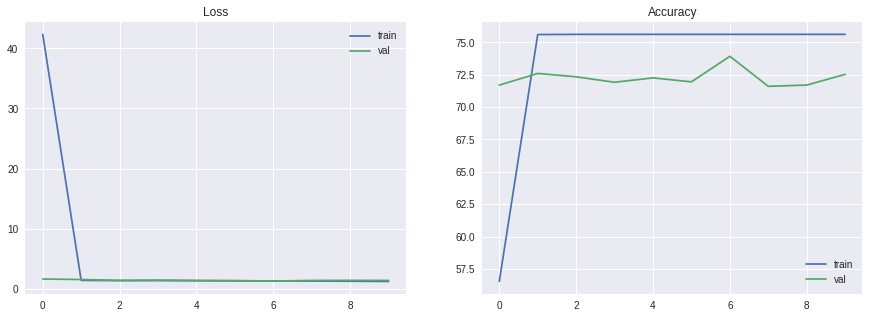

In [17]:
trainer.plot_performance()

In [0]:
trainer.save_train_state()

# TODO

# 新段落

- interpretability via activation maps
- processing images of different sizes
- save split_dataframe (wiht numpy image arrays) to csv and reload dataframe from csv during inference